In [34]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from numpy import linalg as LA
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from IPython.display import clear_output
from tqdm import trange
from scipy.optimize import minimize
import numpy.random as nrd

# modified from TFIM_OICD_noisy.ipynb

# generate Hamiltonian

we consider the transverse-field Ising model,

$$
H=J \sum_{j=1}^{N-1} Z_j Z_{j+1}+\Delta \sum_{j=1}^N X_j
$$

with the coefficient $J=1$ and $\Delta=1.5$. Here $N$ denotes the number of qubits, and $X_j, Z_j$ are Pauli operators acting on the $j$-th qubit.


In [35]:
num_q = 4 ##

# parameters for setting up the Hamiltonian
J = 1
Delta = 1.5

# set H1
List_1 = []
for i in range(num_q-1):
    op = ""
    for k in range(i): # I's before ZZ
        op += "I"
    op += "ZZ"
    for k in range(i+1,num_q-1): # I's after ZZ
        op += "I"
    List_1.append(op)

List_1.reverse()

# example:
# for num_q = 5, List_1 = ['IIIZZ', 'IIZZI', 'IZZII', 'ZZIII']

H1 = SparsePauliOp(List_1, J*np.ones(num_q-1))  

# set H2
List_2 = []
for i in range(num_q):
    op = ""
    for k in range(i):
        op += "I"
    op += "X"
    for k in range(i+1,num_q):
        op += "I"
    List_2.append(op)
    
H2 = SparsePauliOp(List_2, Delta*np.ones(num_q))

# set H = H1 + H2
H = SparsePauliOp.sum([H1,H2])
Hmat = Operator(H)
Hmat = Hmat.data # This is the matrix representation of the Hamiltonian
# Ordering in SparsePauliOp e.g. IIIIIIZZ is the measurement of Z gates on the first 
# two qubits and so forth.

e, v = LA.eig(Hmat) # Compute the eigenvalues and right eigenvectors of a square array.
min_index = np.argmin(e)
v_min = v[:,min_index] # ground state (eigenvector)
ground_e = np.min(e) # ground state energy

# print(H[-1])
print(ground_e)
print(H.size)
print(H)

(-6.5038915571264155+0j)
7
SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'XIII', 'IXII', 'IIXI', 'IIIX'],
              coeffs=[1. +0.j, 1. +0.j, 1. +0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j])


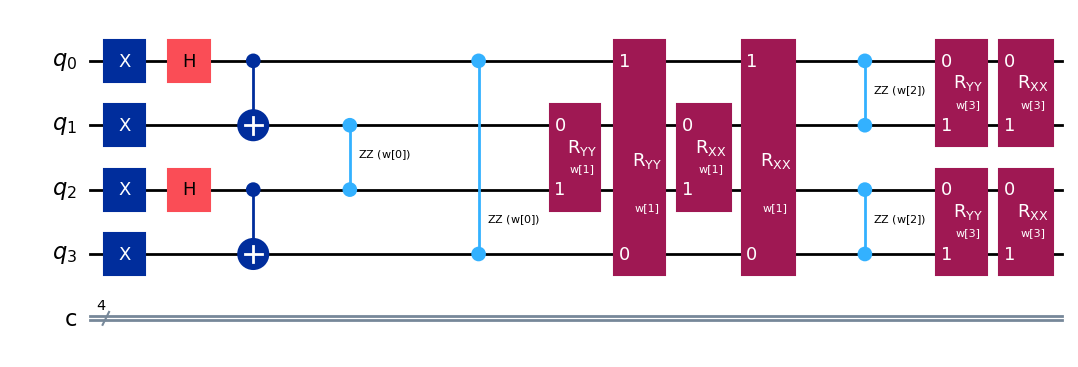

In [36]:
"""Circuit construction"""
layer = 1  # Define the number of layers in the quantum circuit

# This needs to be determined based on the circuit
num_p = layer * 4  # Calculate the number of parameters

weights = ParameterVector("w", num_p)  # Create a vector of parameters (parameters of the quantum circuit)

def circuit_QAOA_XXZ(weights):
    circ = QuantumCircuit(num_q, num_q)
    
    # Input layer to prepare Bell state -\psi
    for j in range(num_q):
        circ.x(j)  # Apply X gate to all qubits, initializing them from |0> to |1>.
    for j in range(int(num_q / 2)):
        # Then, for each pair of adjacent qubits (2j and 2j+1), apply H gate and CX (CNOT) gate to create Bell states.
        circ.h(2 * j)  # Apply Hadamard gate to each pair of qubits to create superposition states
        circ.cx(2 * j, 2 * j + 1)  # Create Bell state: Apply CNOT gate to each pair of qubits

    # QAOA Ansatz (variational layers)
    # Each layer consists of two parts: odd layers and even layers. The total number of layers is 'layer', with 2 sub-layers inside.
    for i in range(layer):
        ## Odd layers
        for j in range(int(num_q / 2)):
            circ.rzz(weights[4 * i], 2 * j + 1, (2 * j + 2) % num_q)  ## ZZ gates in odd sum
            # weights  [0]
        for j in range(int(num_q / 2)):
            circ.ryy(weights[4 * i + 1], 2 * j + 1, (2 * j + 2) % num_q)  ## YY gates in odd sum
            # weights  [1]
        for j in range(int(num_q / 2)):
            circ.rxx(weights[4 * i + 1], 2 * j + 1, (2 * j + 2) % num_q)  ## XX gates in odd sum
            # weights  [1]

        ## Even layers
        for j in range(int(num_q / 2)):
            circ.rzz(weights[4 * i + 2], 2 * j, 2 * j + 1)  ## ZZ gates in even sum
            # weights  [2]
        for j in range(int(num_q / 2)):
            circ.ryy(weights[4 * i + 3], 2 * j, 2 * j + 1)  ## YY gates in even sum
            # weights  [3]
        for j in range(int(num_q / 2)):
            circ.rxx(weights[4 * i + 3], 2 * j, 2 * j + 1)  ## XX gates in even sum
            # weights  [3]

    return circ 

qc = circuit_QAOA_XXZ(weights)
# print(qc)
qc.draw("mpl")


In [24]:
simulator = AerSimulator()

def estimate_loss(WEIGHTS, SHOTS):

    # estimate for ZZ gates in H1
    estimate = 0
    qc = circuit_QAOA_XXZ(WEIGHTS)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) 

    for i in range(SHOTS):
        c_i = c[i]

        for j in range(num_q-1):
            if c_i[num_q-1-j] == c_i[num_q-1-(j+1)]:
                estimate += 1
            else:
                estimate += -1

    estimate = J*estimate/SHOTS
    

    # estimate_1 for X gates in H2
    estimate_1 = 0
    qc = circuit_QAOA_XXZ(WEIGHTS)
    for i in range(num_q):
        qc.h(i)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)
    for i in range(SHOTS):
        c_i = c[i]
        for j in range(num_q):
            if c_i[num_q-1-j] == '0':
                estimate_1 += 1
            else:
                estimate_1 += -1

    estimate_1 = Delta*estimate_1/SHOTS
    
    return estimate + estimate_1



def expectation_loss(WEIGHTS):
    qc = circuit_QAOA_XXZ(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hpsi = Hmat.dot(psi)
    expectation = np.inner(np.conjugate(psi),Hpsi)
    return np.real(expectation)

def fidelity(WEIGHTS):
    qc = circuit_QAOA_XXZ(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    return np.absolute(np.vdot(psi,v_min))**2

def sd(WEIGHTS):
    qc = circuit_QAOA_XXZ(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hmat_sqaured =  Hmat @ Hmat
    Hmat_sqauredpsi = Hmat_sqaured.dot(psi)
    var = np.inner(np.conjugate(psi),Hmat_sqauredpsi) - expectation_loss(WEIGHTS)**2
    return np.sqrt(np.real(var))


In [25]:
weights = np.random.uniform(0, 2*np.pi, size=num_p)

print(expectation_loss(weights))
print(sd(weights))
print(expectation_loss(weights)/sd(weights))

shots = 1000
if False:
    true_value = expectation_loss(weights)

    # 收集多次估计结果
    num_trials = 1000
    estimate_results = [estimate_loss(weights, shots) for _ in range(num_trials)]

    # 绘制结果
    plt.figure(figsize=(10, 6))
    plt.hist(estimate_results, bins=30, density=True, alpha=0.6, color='g', label='Estimation Results')
    plt.axvline(true_value, color='r', linestyle='--', label=f'True Value = {true_value}')
    plt.title('Distribution of estimate_Z outputs')
    plt.xlabel('Estimated Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

    


-0.5278496430599315
2.8743677407923824
-0.18364026132384098


In [26]:
from check_utils import interp_matrix

weights_dict = {}

omegas_1 = list(range(1, num_q // 2 + 1))
interp_nodes_1 = np.linspace(0,2*np.pi,2*len(omegas_1)+1,endpoint=False)
inverse_interp_matrix_1 = np.linalg.inv(interp_matrix(interp_nodes_1, omegas_1))

omegas_2 = list(range(1, (num_q // 2) * 2 + 1))
interp_nodes_2 = np.linspace(0,2*np.pi,2*len(omegas_2)+1,endpoint=False)
inverse_interp_matrix_2 = np.linalg.inv(interp_matrix(interp_nodes_2, omegas_2))

for j in range(num_p):
    if j % 2 == 0: 
        weights_dict[f'weights_{j}'] = {
            'omegas': omegas_1,
            'interp_nodes': interp_nodes_1,
            'inverse_interp_matrix': inverse_interp_matrix_1,
        }
    elif j % 2 == 1:  # even layers with RYY+RXX gates
        weights_dict[f'weights_{j}'] = {
            'omegas': omegas_2,
            'interp_nodes': interp_nodes_2,
            'inverse_interp_matrix': inverse_interp_matrix_2,
        }

print(weights_dict['weights_0'])
print(weights_dict['weights_1'])
print(f'true ground state energy:',ground_e)

{'omegas': [1, 2], 'interp_nodes': array([0.        , 1.25663706, 2.51327412, 3.76991118, 5.02654825]), 'inverse_interp_matrix': array([[ 2.82842712e-01,  2.82842712e-01,  2.82842712e-01,
         2.82842712e-01,  2.82842712e-01],
       [ 4.00000000e-01,  1.23606798e-01, -3.23606798e-01,
        -3.23606798e-01,  1.23606798e-01],
       [-9.44412113e-17,  3.80422607e-01,  2.35114101e-01,
        -2.35114101e-01, -3.80422607e-01],
       [ 4.00000000e-01, -3.23606798e-01,  1.23606798e-01,
         1.23606798e-01, -3.23606798e-01],
       [-1.00603272e-16,  2.35114101e-01, -3.80422607e-01,
         3.80422607e-01, -2.35114101e-01]])}
{'omegas': [1, 2, 3, 4], 'interp_nodes': array([0.        , 0.6981317 , 1.3962634 , 2.0943951 , 2.7925268 ,
       3.4906585 , 4.1887902 , 4.88692191, 5.58505361]), 'inverse_interp_matrix': array([[ 1.57134840e-01,  1.57134840e-01,  1.57134840e-01,
         1.57134840e-01,  1.57134840e-01,  1.57134840e-01,
         1.57134840e-01,  1.57134840e-01,  1.571348

In [27]:
"""optimization phase"""
# mat = scipy.io.loadmat('w0')
# w0 = mat['w0']
# initial_weights = np.zeros(num_p) #np.ones(num_p)
# initial_weights[:10] = w0.flatten()
initial_weights = np.random.uniform(0, 2*np.pi, size=num_p)

n_shot = 1000

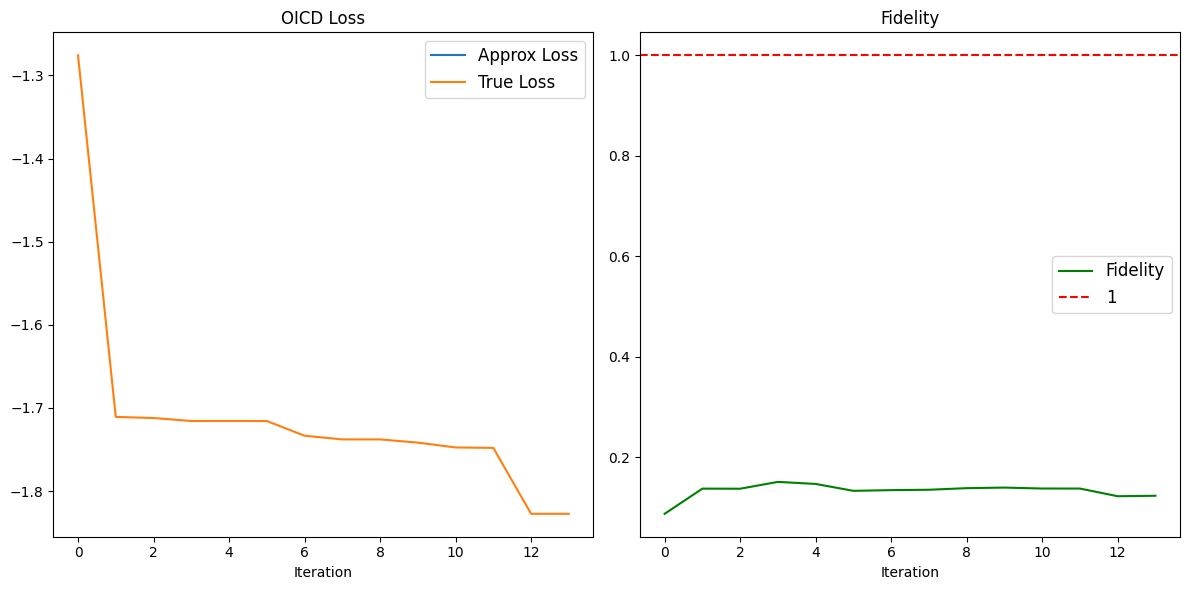

[OICD] Iter: 12 - Coord: 9(40), Best loss: -1.8272735987453368, True loss: -1.8245814994759684, Fidelity: 0.12375997976757185:   1%|          | 13/2000 [00:09<23:18,  1.42it/s]


KeyboardInterrupt: 

In [28]:
# OICD Optimization
from algo.oicd_qiskit import oicd

num_iters = 2000
# Run OICD
final_weights_oicd, best_expected_record_value_oicd, fidelity_record_value_oicd, func_oicd = oicd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iters,
    subproblem_method='CG',  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
    subproblem_iter=None,
    cyclic_mode=False,
    use_solvers_flag=True,
    use_pratical_interp_flag=True,
    exact_mode=False,
    plot_flag=True,
)


In [ ]:

# Gradient Descent Optimization
from algo.gd_qiskit import gd

num_iters = 50
# Run GD
final_weights_gd, best_expected_record_value_gd, fidelity_record_value_gd, func_gd = gd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iters,
    learning_rate=0.05,
    exact_mode=False,
    plot_flag=True,
)


In [ ]:

# RCD Optimization
from algo.rcd_qiskit import rcd

num_iters = 500
# Run RCD
final_weights_rcd, best_expected_record_value_rcd, fidelity_record_value_rcd, func_rcd= rcd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iters,
    learning_rate=0.1,
    cyclic_mode=False,
    exact_mode=False,
    plot_flag=True,
)


In [ ]:
import matplotlib.pyplot as plt

# 创建一个1x2的子图布局
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# 第一个子图：横坐标是累计函数调用次数，纵坐标是函数值
axs[0].plot(func_oicd, best_expected_record_value_oicd, label='OICD', color='blue')
axs[0].plot(func_gd, best_expected_record_value_gd, label='GD', color='green')
axs[0].plot(func_rcd, best_expected_record_value_rcd, label='RCD', color='red')
axs[0].axhline(y=ground_e, color='r', linestyle='--', label='Ground Energy')

# 设置第一个子图的标签和标题
axs[0].set_xlabel('Cumulative Num. of Function Evaluations', fontsize=12)
axs[0].set_ylabel('True Loss', fontsize=12)
axs[0].set_title('True Loss vs. Cumulative Num. of Function Evaluations', fontsize=14)

# 设置x轴范围
# x_range = np.average([func_oicd[-1], func_gd[-1], func_rcd[-1]])
# x_range = max(func_oicd[-1], func_gd[-1], func_rcd[-1])
# x_range = min(func_oicd[-1], func_gd[-1], func_rcd[-1])
x_range = func_oicd[-1]*2
axs[0].set_xlim(0,x_range)

# 显示第一个子图的图例
axs[0].legend()

# 第二个子图：横坐标是迭代次数，纵坐标是函数值
axs[1].plot(best_expected_record_value_oicd, label='OICD', color='blue')
axs[1].plot(best_expected_record_value_gd, label='GD', color='green')
axs[1].plot(best_expected_record_value_rcd, label='RCD', color='red')
axs[1].axhline(y=ground_e, color='r', linestyle='--', label='Ground Energy')

# 设置第二个子图的标签和标题
axs[1].set_xlabel('Iteration Number', fontsize=12)
axs[1].set_ylabel('True Loss', fontsize=12)
axs[1].set_title('True Loss vs. Iteration Number', fontsize=14)

# 设置x轴范围
axs[1].set_xlim(0, min(len(best_expected_record_value_oicd), len(best_expected_record_value_gd), len(best_expected_record_value_rcd)))

# 显示第二个子图的图例
axs[1].legend()

# 显示网格
for ax in axs:
    ax.grid(True)

# 自动调整布局，避免子图之间的标签重叠
plt.tight_layout()

# 显示图形
plt.show()


In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# 第一个子图：横坐标是累计函数调用次数，纵坐标是 Fidelity
axs[0].plot(func_oicd, fidelity_record_value_oicd, label='OICD', color='blue')
axs[0].plot(func_gd, fidelity_record_value_gd, label='GD', color='green')
axs[0].plot(func_rcd, fidelity_record_value_rcd, label='RCD', color='red')
axs[0].axhline(y=1, color='r', linestyle='--', label='1')
# 设置第一个子图的标签和标题
axs[0].set_xlabel('Cumulative Num. of Function Evaluations', fontsize=12)
axs[0].set_ylabel('Fidelity', fontsize=12)
axs[0].set_title('Fidelity vs. Cumulative Num. of Function Evaluations', fontsize=14)

# 设置x轴范围
# x_range = np.average([func_oicd[-1], func_gd[-1], func_rcd[-1]])
# x_range = max(func_oicd[-1], func_gd[-1], func_rcd[-1])
# x_range = min(func_oicd[-1], func_gd[-1], func_rcd[-1])
x_range = func_oicd[-1]*2
axs[0].set_xlim(0,x_range)

# 显示第一个子图的图例
axs[0].legend()

# 第二个子图：横坐标是迭代次数，纵坐标是 Fidelity
axs[1].plot(fidelity_record_value_oicd, label='OICD', color='blue')
axs[1].plot(fidelity_record_value_gd, label='GD', color='green')
axs[1].plot(fidelity_record_value_rcd, label='RCD', color='red')
axs[1].axhline(y=1, color='r', linestyle='--', label='1')
# 设置第二个子图的标签和标题
axs[1].set_xlabel('Iteration Number', fontsize=12)
axs[1].set_ylabel('Fidelity', fontsize=12)
axs[1].set_title('Fidelity vs. Iteration Number', fontsize=14)

# 设置x轴范围
axs[1].set_xlim(0, min(len(fidelity_record_value_oicd), len(fidelity_record_value_gd), len(fidelity_record_value_rcd)))

# 显示第二个子图的图例
axs[1].legend()

# 显示网格
for ax in axs:
    ax.grid(True)

# 自动调整布局，避免重叠
plt.tight_layout()

# 显示图形
plt.show()
